In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from global_land_mask import globe
from functools import partial
from PyOptimalInterpolation.utils import match
from PyOptimalInterpolation.utils import WGS84toEASE2_New, EASE2toWGS84_New, stats_on_vals, glue_local_predictions
from PyOptimalInterpolation.plot_utils import plot_pcolormesh
from PyOptimalInterpolation import get_parent_path, get_data_path
from PyOptimalInterpolation.local_experts import LocalExpertData

2023-04-12 19:06:45.997013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 19:06:46.145194: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-12 19:06:46.618061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64
2023-04-12 19:06:46.618140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.s

Exception:
cannot import name 'banded' from 'banded_matrices' (unknown location)
occurred while trying to import: GPflowASVGPModel


In [2]:
# Check entries in the results table
result_dir = get_parent_path("results", "example") # Location of saved result. Change accordingly.
result_file = "ABC_10km_binned_sgpr_500km_radius.h5" # File name of saved result. Change accordingly
store_path = os.path.join(result_dir, result_file)
with pd.HDFStore(store_path, mode="r") as store:
    all_keys = store.keys()
    print(f"Columns = {all_keys}")
    

Columns = ['/kernel_variance', '/lengthscales', '/likelihood_variance', '/oi_config', '/preds', '/run_details']


In [3]:
with pd.HDFStore(store_path, mode="r") as store:
    # Get predictions
    preds = store.select('preds').reset_index()
    # Get hyperparemeters
    lengthscales = store.select('lengthscales')
    kernel_variance = store.select('kernel_variance')
    likelihood_variance = store.select('likelihood_variance')
    # Get configuration dict
    oi_config = store.get_storer("oi_config").attrs['oi_config']
    run_details = store.select("run_details")

# print(f"Predictions: \n {'-'*10} \n {preds.head()} \n")
print(f"Lengthscales: \n {'-'*15} \n {lengthscales.head()} \n")
print(f"Kernel variance: \n {'-'*15} \n {kernel_variance.head()} \n")
print(f"Likelihood variance \n {'-'*15} \n {likelihood_variance.head()}")


Lengthscales: 
 --------------- 
                                _dim_0  lengthscales
x          y          t                            
-800000.0  -2000000.0 18326.0       0      0.715754
                      18326.0       1      0.451889
                      18326.0       2      4.834000
-1600000.0  1000000.0 18326.0       0      1.753313
                      18326.0       1      1.463063 

Kernel variance: 
 --------------- 
                                _dim_0  kernel_variance
x          y          t                               
-800000.0  -2000000.0 18326.0       0         0.016348
-1600000.0  1000000.0 18326.0       0         0.007853
-1800000.0  1000000.0 18326.0       0         0.008744
-2000000.0  1000000.0 18326.0       0         0.008878
 1600000.0  800000.0  18326.0       0         0.005816 

Likelihood variance 
 --------------- 
                                _dim_0  likelihood_variance
x          y          t                                   
-800000.0  -200000

In [4]:
# Get name of coords (input variables to the GP)
coords_col = oi_config['data']['coords_col']
# Extract predictions only where it is not NaN
preds = preds.loc[~np.isnan(preds["f*"])]
print(f"Optimal Interpolation results: \n {'-'*30} \n {preds.head()}")
# Get xy coordinates of prediction locations
pred_locs = preds[['pred_loc_x', 'pred_loc_y']].drop_duplicates()

Optimal Interpolation results: 
 ------------------------------ 
           x          y        t  _dim_0        f*    f*_var     y_var  f_bar  \
0 -800000.0 -2000000.0  18326.0       0 -0.000040  0.016348  0.044227    0.0   
1 -800000.0 -2000000.0  18326.0       1 -0.000028  0.016348  0.044227    NaN   
2 -800000.0 -2000000.0  18326.0       2 -0.000020  0.016348  0.044227    NaN   
3 -800000.0 -2000000.0  18326.0       3 -0.000014  0.016348  0.044227    NaN   
4 -800000.0 -2000000.0  18326.0       4 -0.000010  0.016348  0.044227    NaN   

   pred_loc_x  pred_loc_y  pred_loc_t  
0   -997500.0  -2027500.0     18326.0  
1   -997500.0  -2022500.0     18326.0  
2   -997500.0  -2017500.0     18326.0  
3   -997500.0  -2012500.0     18326.0  
4   -997500.0  -2007500.0     18326.0  


In [5]:
# Compute run time
run_time = run_details['run_time'].sum()
print(f"Total run time: {run_time / 60 / 60:.3f} hours")

Total run time: 0.838 hours


In [6]:
# # take simple average of predictions made by overlapping expert models
# pcoord_cols = [f"pred_loc_{c}" for c in coords_col]
# avg_preds = pd.pivot_table(preds,
#                            index=pcoord_cols,
#                            values=['f*', "f*_var", "y_var"],
#                            aggfunc='mean').reset_index()

# take Gaussian weighted average of predictions made by overlapping expert models
expert_locs_df = pd.read_csv("/home/so/Documents/Projects/PyOptimalInterpolation/data/locations/example_expert_locations_arctic.csv")
avg_preds = glue_local_predictions(preds, expert_locs_df)

avg_preds['lon'], avg_preds['lat'] = EASE2toWGS84_New(avg_preds['pred_loc_x'], avg_preds['pred_loc_y'])

# remove predictions over land
avg_preds["is_in_ocean"] = globe.is_ocean(avg_preds['lat'], avg_preds['lon'])

avg_preds = avg_preds.loc[avg_preds['is_in_ocean']]

avg_preds.head()

,pred_loc_x,pred_loc_y,f*,f*_std,lon,lat,is_in_ocean
0,-2997500.0,-627500.0,-0.000028,0.121142,-78.176382,62.291961,True
1,-2997500.0,-622500.0,-0.000034,0.121142,-78.267973,62.301392,True
2,-2997500.0,-617500.0,-0.000040,0.121142,-78.359625,62.310751,True
3,-2997500.0,-612500.0,-0.000046,0.121142,-78.451336,62.320038,True
4,-2997500.0,-607500.0,-0.000054,0.121142,-78.543108,62.329251,True


In [7]:
# Map predictions onto a 2d array for plotting
# - assumes predictions are already on some sort of regular grid!
delta_x = np.diff(np.sort(avg_preds['pred_loc_x'].unique())).min()
delta_y = np.diff(np.sort(avg_preds['pred_loc_y'].unique())).min()

x_start = avg_preds['pred_loc_x'].min()
x_end = avg_preds['pred_loc_x'].max()
x_coords = np.arange(x_start, x_end + delta_x, delta_x)

y_start = avg_preds['pred_loc_y'].min()
y_end = avg_preds['pred_loc_y'].max()
y_coords = np.arange(y_start, y_end + delta_y, delta_y)

x_grid, y_grid = np.meshgrid(x_coords, y_coords)

avg_preds['grid_loc_x'] = match(avg_preds['pred_loc_x'].values, x_coords)
avg_preds['grid_loc_y'] = match(avg_preds['pred_loc_y'].values, y_coords)

# check there is only one grid_loc for each point
avg_preds[['grid_loc_x', 'grid_loc_y']].drop_duplicates().shape[0] == avg_preds.shape[0]

lon_grid, lat_grid = EASE2toWGS84_New(x_grid, y_grid)

# populate a 2d array of values to plot
avg_mean_2d = np.full(x_grid.shape, np.nan)
avg_std_2d = np.full(x_grid.shape, np.nan)

avg_mean_2d[avg_preds['grid_loc_y'].values, avg_preds['grid_loc_x'].values] = avg_preds['f*'].values
# avg_std_2d[avg_preds['grid_loc_y'].values, avg_preds['grid_loc_x'].values] = np.sqrt(avg_preds['f*_var'].values)
avg_std_2d[avg_preds['grid_loc_y'].values, avg_preds['grid_loc_x'].values] = avg_preds['f*_std'].values


In [8]:
from dataclasses import dataclass
from typing import Union


@dataclass
class PlotConfig:
    """Configuration data class for plotting"""
    plot_data: np.ndarray
    lon: np.ndarray
    lat: np.ndarray
    cbar_label: str
    title: str
    marker_size: int = 1
    abs_vminmax: bool = False           # Flag for impose an absolute vmin/vmax or not
    vmin: Union[None, float] = None     # Absolute vmin
    vmax: Union[None, float] = None     # Absolute vmax
    q_vmin: Union[None, float] = 0.05   # Minimal quantile
    q_vmax: Union[None, float] = 0.95   # Maximal quantile
    cmap: str = 'YlGnBu_r'


def plot_helper(fig, nrows, ncols, plt_idx, plot_config: PlotConfig):
    # extract plot parameters
    plot_data = plot_config.plot_data
    title = plot_config.title

    # extract parameters - specific to plot pcolor mesh
    lon, lat = plot_config.lon, plot_config.lat
    cbar = plot_config.cbar_label
    abs_vminmax = plot_config.abs_vminmax
    s = plot_config.marker_size
    vmin_max = [plot_config.vmin, plot_config.vmax]
    cmap = plot_config.cmap

    q_vminmax = [plot_config.q_vmin, plot_config.q_vmax]
    if vmin_max[0] is None and vmin_max[1] is None:
        if not abs_vminmax:
            vmin, vmax = np.nanquantile(plot_data, q=q_vminmax)
        else:
            max_q = max(q_vminmax) if isinstance(q_vminmax, (tuple, list)) else q_vminmax

            vmax = np.nanquantile(np.abs(plot_data), q=max_q)
            vmin = -vmax
    else:
        vmin, vmax = vmin_max[0], vmin_max[1]

    # first plot: heat map of observations
    ax = fig.add_subplot(nrows, ncols, plt_idx,
                            projection=ccrs.NorthPolarStereo())

    scatter = len(plot_data.shape) == 1

    plot_pcolormesh(ax,
                    lon=lon,
                    lat=lat,
                    plot_data=plot_data,
                    scatter=scatter,
                    vmin=vmin,
                    vmax=vmax,
                    s=s,
                    fig=fig,
                    cbar_label=cbar,
                    cmap=cmap)

    plt.title(title)

    return fig

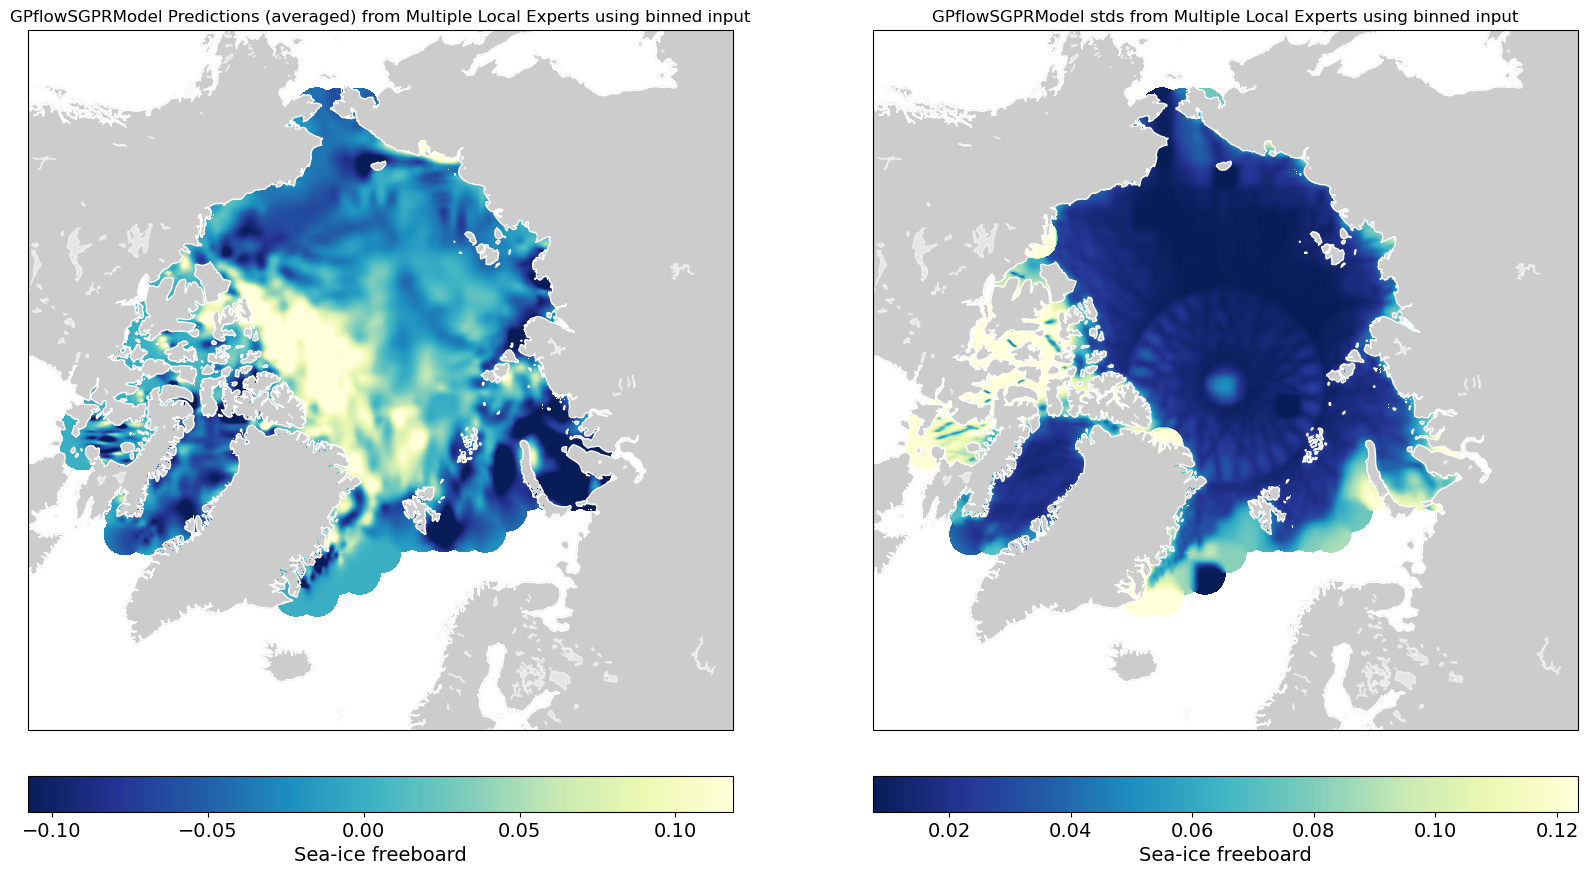

In [9]:
# Plot predictive mean and std
mean_plot_config = PlotConfig(
    plot_data = avg_mean_2d,
    lon = lon_grid,
    lat = lat_grid,
    cbar_label = "Sea-ice freeboard",
    title = f"{oi_config['model']['oi_model']} Predictions (averaged) from Multiple Local Experts using "
                f"binned input"
)

std_plot_config = PlotConfig(
    plot_data = avg_std_2d,
    lon = lon_grid,
    lat = lat_grid,
    cbar_label = "Sea-ice freeboard",
    title = f"{oi_config['model']['oi_model']} stds from Multiple Local Experts using "
                f"binned input"
)

fig_size = (20, 20)
fig = plt.figure(figsize=fig_size)
plot_mean_std = partial(plot_helper, nrows=1, ncols=2)
configs = [mean_plot_config, std_plot_config]
plt_idx = 0
for i, config in enumerate(configs):
    plt_idx += 1
    fig = plot_mean_std(fig=fig,
                        plt_idx=plt_idx,
                        plot_config=config)



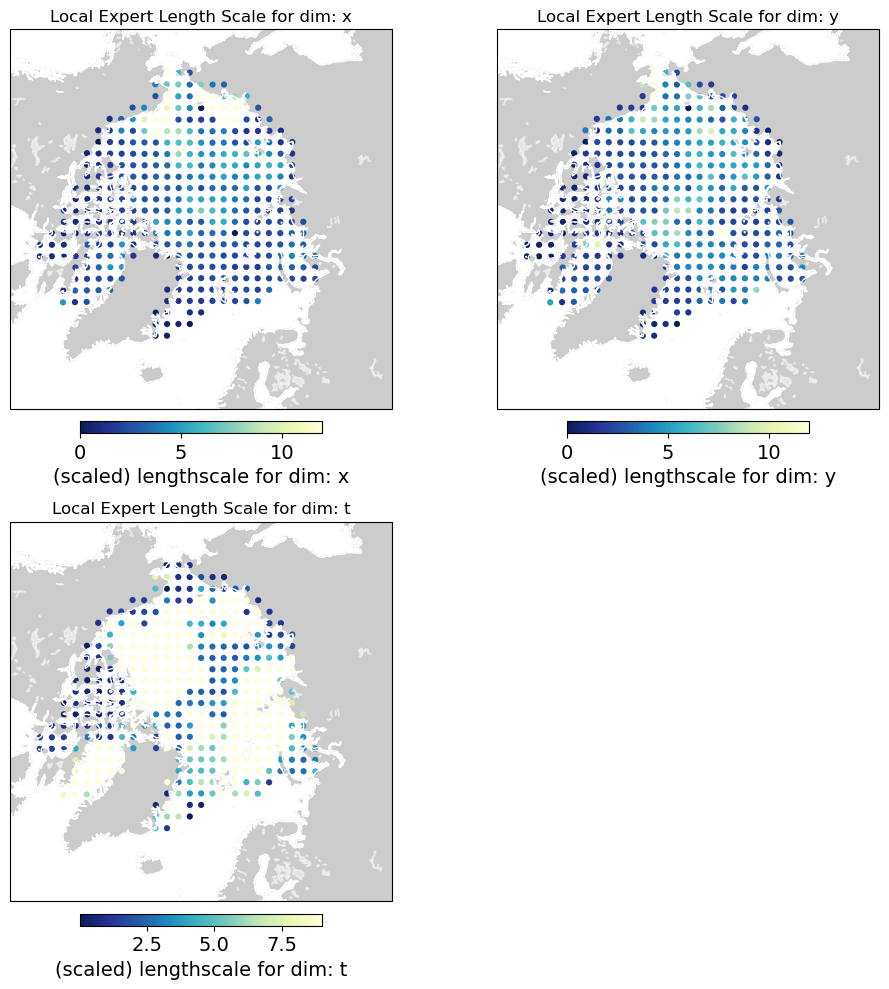

In [10]:
# Plot lengthscales
dim_map = {i: cc for i, cc in enumerate(coords_col)}

lengthscales = lengthscales.reset_index()
lengthscales['dim_name'] = lengthscales['_dim_0'].map(dim_map)
lengthscales['lon'], lengthscales['lat'] = EASE2toWGS84_New(lengthscales['x'], lengthscales['y'])

lengthscales_configs = []
for cc in coords_col:

    _ = lengthscales.loc[lengthscales['dim_name'] == cc]

    _plot_config = PlotConfig(
        plot_data = _['lengthscales'],
        lon = _['lon'],
        lat = _['lat'],
        cbar_label = f"(scaled) lengthscale for dim: {cc}",
        title = f"Local Expert Length Scale for dim: {cc}",
        marker_size = 20,
        q_vmin = 0.001,
        q_vmax = 0.999
    )
    lengthscales_configs.append(_plot_config)

plot_lengthscales = partial(plot_helper, nrows=2, ncols=2)

fig_size = (10, 10)
fig = plt.figure(figsize=fig_size)
plt_idx = 0
for i, config in enumerate(lengthscales_configs):
    plt_idx += 1
    fig = plot_lengthscales(fig=fig,
                            plt_idx=plt_idx,
                            plot_config=config)

plt.tight_layout()


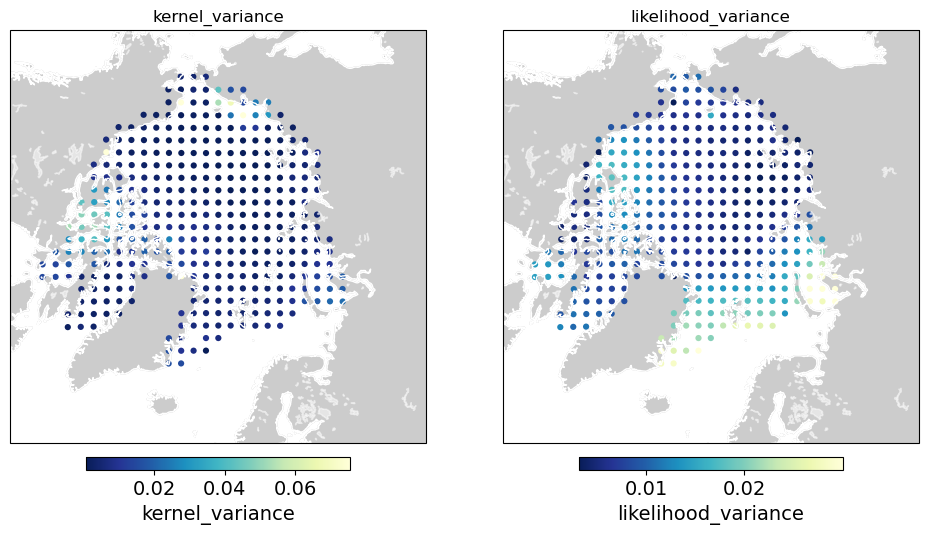

In [11]:
# Plot variances
variances = {'kernel_variance': kernel_variance,
             'likelihood_variance': likelihood_variance}

variance_configs = []
for var_name, variance in variances.items():
    variance = variance.reset_index()
    variance['lon'], variance['lat'] = EASE2toWGS84_New(variance['x'], variance['y'])
    # likelihood_variance = likelihood_variance.reset_index()

    _var_config = PlotConfig(
            plot_data = variance[var_name],
            lon = variance['lon'],
            lat = variance['lat'],
            cbar_label = f"{var_name}",
            title = f"{var_name}",
            marker_size = 20,
            q_vmin = 0.01,
            q_vmax = 0.99
        )

    variance_configs.append(_var_config)

plot_variances = partial(plot_helper, nrows=1, ncols=2)

fig_size = (10, 10)
fig = plt.figure(figsize=fig_size)
plt_idx = 0
for i, config in enumerate(variance_configs):
    plt_idx += 1
    fig = plot_lengthscales(fig=fig,
                            plt_idx=plt_idx,
                            plot_config=config)

plt.tight_layout()

In [12]:
# Save pdf
